In [4]:
import os
import re 
# !pip install pandas
# !pip install watermark
# ! pip install seaborn
# !pip install numba
# !pip install numba
from numba import jit
import pandas as pd
import numpy as np 
# pip install Cython 

import seaborn as sns
import watermark
import random 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math
# from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = 'all'
%load_ext watermark
%watermark
%watermark --iversion

Last updated: 2021-05-01T17:22:27.366766+08:00

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 11, GenuineIntel
CPU cores   : 8
Architecture: 64bit

pandas    : 1.2.4
numpy     : 1.20.1
watermark : 2.2.0
seaborn   : 0.11.1
re        : 2.2.1
matplotlib: 3.3.4



In [5]:
left=2
right=6 
signal_num = left+right
bases="ACGT"
lower_bases="acgt"
noknown_bases="nksrywmbv"

priorP=pd.read_csv("output/donor_prior_probability_(P+).csv",index_col=[0])
priorN=pd.read_csv("output/prior_probability_(P-).csv",index_col=[0])
conditionalP=pd.read_csv("output/donor_conditionalDf_probability(P+).csv",index_col=[0])
conditionalN=pd.read_csv("output/conditionalDf_probability(P-).csv",index_col=[0])
all_donor_signal=pd.read_csv("output/Train_donor_signal_info.csv")
# priorN
conditionalP
# conditionalN
# all_donor_signal
# 读取donor片段
def read_donors(filename):
    donors = []
    f = open(filename)
    lines = f.readlines()
    for line in lines:
        donors.append(line.strip('\n'))
    f.close()
    print('read donors successful!')
    return donors
donor_strs=read_donors("output/Train_donor_signal_str.txt")
test_donor_strs=read_donors("output/Test_donor_signal_str.txt")

read donors successful!
read donors successful!


In [6]:
priorP.iloc[0]
priorP.iloc[0][1]
priorP.iloc[0,1]

0.1377572448551029

In [7]:
donor_strs[1]

'tcgtaagt'

In [8]:
priorP = np.array(priorP)
priorN = np.array(priorN)
conditionalP = np.array(conditionalP)
conditionalN = np.array(conditionalN)

In [9]:
def log_c(num,ex_mini=10e-9):
    if num == 0:
        return np.log(ex_mini)
    else:
        return np.log(num)

def process_donors(donors):
    char_to_int = {c:i for i, c in enumerate(lower_bases)}
    integer_encoded = [char_to_int[char] for char in donors]
    return np.array(integer_encoded)

# @jit(nopython=True)
# def WAM_formula():
    
def cal_WAM(seq, priorA=priorP[0], priorB=priorN[0], conditionalA=conditionalP, conditionalB=conditionalN):
#     print(seq)
    # 计算得分
    seq = process_donors(seq)
    S = np.log(priorA[seq[0]]) - np.log(priorB[seq[0]])
    
    for i in range(signal_num-1):
            S += log_c(conditionalA[i,seq[i]*4+seq[i+1]]) - log_c(conditionalB[i,seq[i]*4+seq[i+1]])
    return S


donor_strs = tqdm(donor_strs, desc='Calculating Donor signal score:')
scores=list(map(cal_WAM,donor_strs))
len(scores)
type(scores)
# scores

Calculating Donor signal score::   0%|          | 0/2381 [00:00<?, ?it/s]

list

In [10]:
s = pd.Series(scores)
print(s.describe())

count    2381.000000
mean        5.678813
std         1.485804
min        -2.217162
25%         4.663160
50%         5.603827
75%         6.857882
max         8.407037
dtype: float64


In [11]:
# sns.set()
# ax = sns.distplot(scores)
# distplot不能用了。

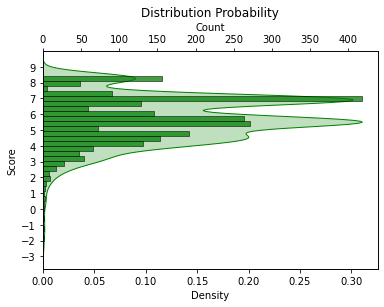

In [12]:
ax = sns.kdeplot(y=scores,shade=True,color="g",bw_adjust=1,cut=3)
ax.set_xlabel("Density");
ax.set_ylabel("Score");
ax2 = plt.twiny()
ax2 = sns.histplot(y=scores,ax=ax2,color="g")
ax2.set_title('Distribution Probability')
ax2.set(xlabel='Count')
ax2.set_yticks(np.linspace(-4,10,15))
plt.show();
fig = ax.get_figure()
fig.savefig('output/Distribution_Probability_x-left{left}-right{right}.png',dpi = 400) #路径+文件名


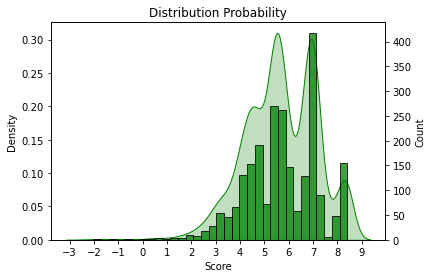

In [13]:
ax1 = sns.kdeplot(scores,shade=True,color="g",bw_adjust=1,cut=3)
ax1.set_ylabel('Density')
ax1.set_xlabel("Score")
ax2 = plt.twinx()
ax2 = sns.histplot(scores,ax=ax2,color="g")
ax2.set_title('Distribution Probability')
ax2.set(ylabel='Count', xlabel='Number of Flavors Purchased')
ax2.set_xticks(np.linspace(-4,10,15))
plt.show();
fig = ax1.get_figure()
fig.savefig('output/Distribution_Probability_y-left{left}-right{right}.png',dpi = 400) #路径+文件名

考虑到最后一个外显子没有donor site后，分值明显高了很多
下一步目标
- 设定阈值分布，然后统计不同阈值的效果，sp，sn曲线？
- 如果确定输出的那个值会是donor site呢
走起！

In [14]:
testdf=pd.read_csv("output/Test_set_info.csv")
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Path              570 non-null    object
 1   Locus             570 non-null    object
 2   Length            570 non-null    int64 
 3   Exon Num          570 non-null    int64 
 4   Exon Location     570 non-null    object
 5   Donor Site        570 non-null    object
 6   Acceptor Site     570 non-null    object
 7   Donor signals     570 non-null    object
 8   Acceptor signals  570 non-null    object
 9   Seq               570 non-null    object
dtypes: int64(2), object(8)
memory usage: 44.7+ KB


In [15]:
testdf.head()

,Path,Locus,Length,Exon Num,Exon Location,Donor Site,Acceptor Site,Donor signals,Acceptor signals,Seq
0,Testing Set/ACU08131.TXT,ACU08131,5392,6,"[('521', '641'), ('1066', '1362'), ('1860', '2...","[642, 1363, 2029, 2803, 3798]","[1065, 1859, 2636, 3557, 4130]","['gggtgagc', 'tggtaaga', 'aggtgagt', 'cggtaggt...","['tggcaggc', 'ccataggt', 'ctctaggt', 'acacaggt...",ctgggctaaaaggtcccttagcctatttagaaaaatgggccattag...
1,Testing Set/AGGGLINE.TXT,AGGGLINE,7360,3,"[('3066', '3157'), ('3281', '3503'), ('4393', ...","[3158, 3504]","[3280, 4392]","['aggtaggc', 'gggtgagt']","['tcacaggc', 'caacagct']",caaggctgctgtcactagcctgtggggcaaggtgaatgtggaagat...
2,Testing Set/AGU04852.TXT,AGU04852,10984,5,"[('3951', '3955'), ('5434', '5516'), ('5810', ...","[3956, 5517, 5912, 6740]","[5433, 5809, 6664, 7636]","['aggtgggt', 'aggtcagt', 'cggtaaga', 'aggtgggt']","['ctgcagtg', 'ttgcagat', 'ttttagga', 'tgacagta']",gaattcaatactccactttccattctgttcaaaggtcacgtatagt...
3,Testing Set/ALOEGLOBIM.txt,ALOEGLOBIM,1691,3,"[('145', '236'), ('360', '582'), ('1392', '152...","[237, 583]","[359, 1391]","['aggtaagc', 'gggtgagt']","['tcataggc', 'taacagct']",ccttgaccaatgactttcaagtaccacggaaaacaggggggcagaa...
4,Testing Set/ALOEGLOBIN.txt,ALOEGLOBIN,1691,3,"[('145', '236'), ('360', '582'), ('1392', '152...","[237, 583]","[359, 1391]","['aggtaagc', 'gggtgagt']","['tcataggc', 'taacagct']",ccttgaccaatgacttttaagtaccacggaaaacaggggggcagaa...


In [16]:
test_donorSite_strs=testdf.loc[:,"Donor Site"] 
test_donor_list = []
for file in test_donorSite_strs:
    str_list = re.findall('\d+',file)
    test_donor_list.append([int(pos)for pos in str_list])
test_seqLength_list=testdf.loc[:,"Length"]
test_signal_list=testdf.loc[:,"Donor signals"]
test_seq_list = testdf.loc[:,"Seq"]
test_locus_list=testdf.loc[:,"Locus"]
file_num=len(test_seqLength_list)
signal_list = []
for file in test_signal_list:
    signal_list.append(re.findall('\'([a-z]+)\'',file))
# type(test_seq_list[0])

In [1]:
test_donor_list[1]

NameError: name 'test_donor_list' is not defined

In [2]:
signal_list[1:3:4]

NameError: name 'signal_list' is not defined

In [3]:

list(map(cal_WAM,signal_list[1]))


NameError: name 'cal_WAM' is not defined

In [24]:
re.findall('\'([a-z]+)\'',"['ggggtgagc', 'gtggtaaga', 'taggtgagt', 'gcggtaggt', 'caggtaatt']")

['ggggtgagc', 'gtggtaaga', 'taggtgagt', 'gcggtaggt', 'caggtaatt']

In [18]:
Sn_list = []
Sp_list = []
P_list= []
threshold_range = tqdm(np.linspace(-4,10,29), desc='Threshold Picking:')
df_all_threshold =pd.DataFrame(columns=["Threshold","Predict Sites","Positive Sites",\
                                "Negative Sites","Actual Donor Sites","Predict Count","TP","FP","TN","FN"])
TNs =[]
TPs =[]
FNs =[]
FPs =[]
pattern = re.compile("[^acgt]")
# def predict_file(i):
    
for threshold in threshold_range:
    files_scores = []
    files_predict_sites = []
    total_count=TP =FP = FN =TN =0
    files_negative_sites = []
    files_positive_sites = []
    TP_counts = []
    FP_counts = []
    FN_counts = []
    TN_counts = []
    predict_counts = []
    files = tqdm(range(file_num), desc='Predicting:')
    for i in files:
        TP_count = 0
        FP_count = 0
        FN_count = 0
        predict_count = 0
        seq= test_seq_list[i]
        seq_length = test_seqLength_list[i]
        scores = []
        predict_sites = []
        positive_sites = []
        negative_sites = []
        for pos in  range(seq_length-signal_num+1):
            signal = seq[pos:pos+signal_num]
            no_known =pattern.search(signal)
            if no_known:
               continue
            else:
                s=cal_WAM(signal)
                predict_count +=1
                if s > threshold:
                    scores.append(s)
                    predict_site= pos+left+1
                    predict_sites.append(predict_site)
                    if predict_site in test_donor_list[i]:
                        TP_count +=1
                        positive_sites.append(predict_site)
                    else:
                        FP_count +=1
                        negative_sites.append(predict_site)
        TP += TP_count
        FP += FP_count
        FN_count = len(test_donor_list[i])-TP_count
        FN += FN_count
        TN_count = predict_count-TP_count-FP_count-FN_count
        total_count +=predict_count
        files_scores.append(scores)
        files_predict_sites.append(predict_sites)
        files_positive_sites.append(positive_sites)
        files_negative_sites.append(negative_sites)
        TP_counts.append(TP_count)
        FP_counts.append(FP_count)
        FN_counts.append(FN_count)
        TN_counts.append(TN_count)
        predict_counts.append(predict_count)
    df_threshold=pd.DataFrame({"Threshold":threshold,"Locus":test_locus_list[0:file_num],"Predict Sites":files_predict_sites,\
      "Positive Sites":files_positive_sites,"Negative Sites":files_negative_sites,"Actual Donor Sites":test_donor_list[0:file_num],\
                  "Predict Num":predict_counts,"Predict Positive Num":np.sum([TP_counts,FP_counts], axis=0),"Predict Negative Num":np.sum([TN_counts,FN_counts], axis=0),"TP":TP_counts,"FP":FP_counts,"TN":TN_counts,"FN":FN_counts})
    df_threshold.to_csv(f"predict/Threshold_{threshold}_file_info.csv",index=None)
    df_all_threshold = pd.concat([df_all_threshold,df_threshold]).reset_index(drop=True)
    TN = total_count-TP-FN-FP
    TPR = TP/(TP+FN)
    TNR = TN / (FP+TN) # 我总算知道为什么sp用的是这个公式，而不是正常的公式了，阈值高于0时，sp会特别大，至少0.9++，所以看不出太大差异
    FPR = 1-TNR
    try:
        P = TP/(TP+FP)
        print(f"When threshold is {threshold:},Sn is: {TPR:.3f},Precision is: {P:.3f},Sp is {TNR:.3f},FPR is {FPR:.3f}")
    except ZeroDivisionError:
        P = None
        print(f"When threshold is {threshold:},Sn is: {TPR:.3f},Precision is: None ,Sp is {TNR:.3f},FPR is {FPR:.3f}") 
    Sn_list.append(TPR)
    Sp_list.append(TNR)
    P_list.append(P)
    TNs.append(TN)
    TPs.append(TP)
    FNs.append(FN)
    FPs.append(FP)
df_threshold.to_csv("predict/Threshold_all_file_info.csv",index=None)
df_all_threshold=pd.DataFrame({"Threshold":list(threshold_range),\
                  "TP":TPs,"FP":FPs,"TN":TNs,"FN":FNs,"Sn":Sn_list,"Sp":Sp_list,"Precision":P_list})

df_all_threshold["FPR"] = 1-df_all_threshold["Sp"]
df_all_threshold["Acc"] = (df_all_threshold["TP"]+df_all_threshold["TN"])/(df_all_threshold["TP"]+df_all_threshold["FP"]\df_all_threshold["TN"]+df_all_threshold["FN"])
df_all_threshold.to_csv("predict/All_Threshold_info.csv",index=None)

Threshold Picking::   0%|          | 0/29 [00:00<?, ?it/s]

Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is -4.0,Sn is: 1.000,Precision is: 0.014,Sp is 0.949,FPR is 0.051


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is -3.5,Sn is: 1.000,Precision is: 0.014,Sp is 0.950,FPR is 0.050


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is -3.0,Sn is: 1.000,Precision is: 0.015,Sp is 0.952,FPR is 0.048


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is -2.5,Sn is: 1.000,Precision is: 0.016,Sp is 0.955,FPR is 0.045


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is -2.0,Sn is: 1.000,Precision is: 0.017,Sp is 0.959,FPR is 0.041


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is -1.5,Sn is: 0.999,Precision is: 0.019,Sp is 0.963,FPR is 0.037


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is -1.0,Sn is: 0.999,Precision is: 0.021,Sp is 0.966,FPR is 0.034


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is -0.5,Sn is: 0.999,Precision is: 0.023,Sp is 0.969,FPR is 0.031


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 0.0,Sn is: 0.999,Precision is: 0.026,Sp is 0.973,FPR is 0.027


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 0.5,Sn is: 0.997,Precision is: 0.031,Sp is 0.977,FPR is 0.023


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 1.0,Sn is: 0.996,Precision is: 0.038,Sp is 0.982,FPR is 0.018


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 1.5,Sn is: 0.993,Precision is: 0.048,Sp is 0.986,FPR is 0.014


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 2.0,Sn is: 0.990,Precision is: 0.065,Sp is 0.990,FPR is 0.010


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 2.5,Sn is: 0.982,Precision is: 0.084,Sp is 0.992,FPR is 0.008


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 3.0,Sn is: 0.964,Precision is: 0.110,Sp is 0.994,FPR is 0.006


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 3.5,Sn is: 0.932,Precision is: 0.140,Sp is 0.996,FPR is 0.004


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 4.0,Sn is: 0.894,Precision is: 0.179,Sp is 0.997,FPR is 0.003


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 4.5,Sn is: 0.796,Precision is: 0.254,Sp is 0.998,FPR is 0.002


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 5.0,Sn is: 0.708,Precision is: 0.327,Sp is 0.999,FPR is 0.001


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 5.5,Sn is: 0.591,Precision is: 0.410,Sp is 0.999,FPR is 0.001


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 6.0,Sn is: 0.444,Precision is: 0.495,Sp is 1.000,FPR is 0.000


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 6.5,Sn is: 0.395,Precision is: 0.524,Sp is 1.000,FPR is 0.000


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 7.0,Sn is: 0.219,Precision is: 0.551,Sp is 1.000,FPR is 0.000


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 7.5,Sn is: 0.103,Precision is: 0.682,Sp is 1.000,FPR is 0.000


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 8.0,Sn is: 0.068,Precision is: 0.641,Sp is 1.000,FPR is 0.000


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 8.5,Sn is: 0.000,Precision is: None ,Sp is 1.000,FPR is 0.000


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 9.0,Sn is: 0.000,Precision is: None ,Sp is 1.000,FPR is 0.000


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 9.5,Sn is: 0.000,Precision is: None ,Sp is 1.000,FPR is 0.000


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 10.0,Sn is: 0.000,Precision is: None ,Sp is 1.000,FPR is 0.000


In [101]:
# i=1
# threshold=-4
# TP_count = 0
# FP_count = 0
# FN_count = 0
# predict_count = 0
# scores = []
# predict_sites = []
# positive_sites = []
# negative_sites = []
# seq = "CTGGGAAGGTAGGCTCTGG".lower()
# print(seq)
# seq_length=len(seq)
# print(seq_length)
# signals = []
# predict_signals = []
# for pos in range(seq_length-signal_num+1):
#     signal = seq[pos:pos+signal_num]
#     no_known =pattern.search(signal)
#     if no_known:
#         break
#     else:
#         signals.append(signal)
#         s=cal_WAM(signal)
#         predict_count +=1
#         if s > threshold:
#             scores.append(s)
#             predict_site= pos+4
#             predict_sites.append(predict_site)
#             predict_signals.append(signal)
            
# print(signals)
# print(signals)
# print(predict_sites)
# print(predict_signals)

ctgggaaggtaggctctgg
19
['ctgggaagg', 'tgggaaggt', 'gggaaggta', 'ggaaggtag', 'gaaggtagg', 'aaggtaggc', 'aggtaggct', 'ggtaggctc', 'gtaggctct', 'taggctctg', 'aggctctgg']
['ctgggaagg', 'tgggaaggt', 'gggaaggta', 'ggaaggtag', 'gaaggtagg', 'aaggtaggc', 'aggtaggct', 'ggtaggctc', 'gtaggctct', 'taggctctg', 'aggctctgg']
[9]
['aaggtaggc']


In [19]:
df_all_threshold= pd.read_csv("predict/All_Threshold_info.csv")
df_all_threshold.head()

,Threshold,TP,FP,TN,FN,Sn,Sp,Precision,FPR
0,-4.0,2079,147817,2736500,0,1.000000,0.948751,0.013870,0.051249
1,-3.5,2079,144079,2740238,0,1.000000,0.950047,0.014224,0.049953
2,-3.0,2079,137943,2746374,0,1.000000,0.952175,0.014848,0.047825
3,-2.5,2078,128789,2755528,1,0.999519,0.955349,0.015879,0.044651
4,-2.0,2078,117933,2766384,1,0.999519,0.959112,0.017315,0.040888


In [20]:
cal_WAM("aaggtaggc")
cal_WAM("agggtgagt")

-31.667484582728992

In [21]:
df_all_threshold = df_all_threshold.set_index("Threshold",drop=True)

<Figure size 432x288 with 0 Axes>

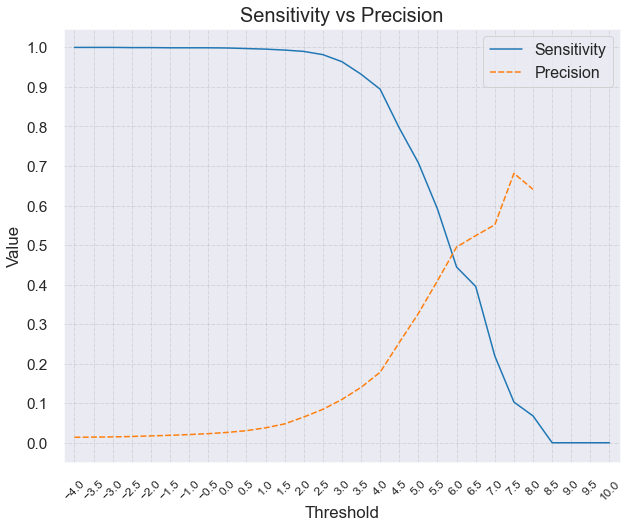

In [24]:
# plt.plot(list(threshold_range),,label="Sn",color='blue',lw=1.5,)
# plt.plot(ldf_all_threshold ist(threshold_range),,label="Sp",color='red',lw=1.5)
sns.set_context("poster",font_scale=0.7)
# sns.set_style("ticks")
sns.despine()
f,ax = plt.subplots(figsize=(10,8))
sns.set(style="darkgrid") # sns.set(style="white")
sns.lineplot(data=[df_all_threshold["Sn"],df_all_threshold["Precision"]],palette="tab10",ax = ax)
# ax = sns.lineplot(x="Threshold",y="Precision",data=df_all_threshold,palette="tab10")
plt.xticks( np.arange(-4, 10.5,0.5),rotation=45,fontsize=12)
ax.set_yticks( np.arange(0, 1.1, 0.1))
plt.xlim([-4.3,10.3])
ax.grid(True,linestyle = "-.",color = 'gray' ,linewidth = '0.5',alpha=0.4)
ax.set_ylabel("Value")
ax.legend(labels=["Sensitivity","Precision"],fontsize=16)
plt.title("Sensitivity vs Precision",fontsize=20)
plt.savefig(f"predict/Sensitivity vs Precision-left{left}-right{right}.png",dpi=400)

<Figure size 432x288 with 0 Axes>

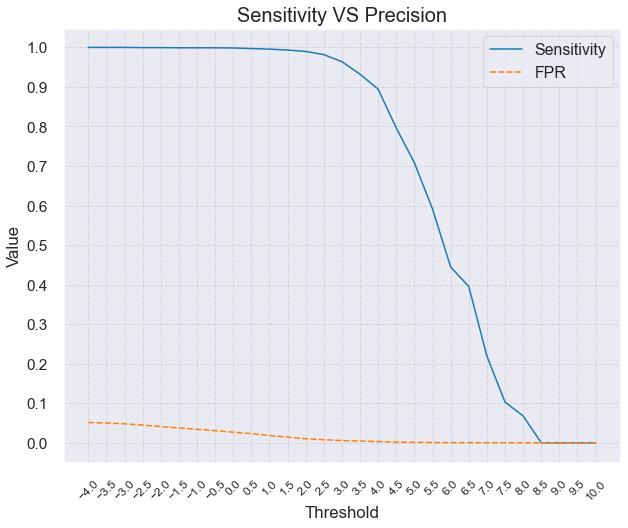

In [26]:
# plt.plot(list(threshold_range),,label="Sn",color='blue',lw=1.5,)
# plt.plot(ldf_all_threshold ist(threshold_range),,label="Sp",color='red',lw=1.5)
sns.set_context("poster",font_scale=0.7)
# sns.set_style("ticks")
sns.despine()
f,ax = plt.subplots(figsize=(10,8))
sns.set(style="darkgrid") # sns.set(style="white")
sns.lineplot(data=[df_all_threshold["Sn"],df_all_threshold["FPR"]],palette="tab10",ax = ax)
# ax = sns.lineplot(x="Threshold",y="Precision",data=df_all_threshold,palette="tab10")
plt.xticks( np.arange(-4, 10.5,0.5),rotation=45,fontsize=12)
ax.set_yticks( np.arange(0, 1.1, 0.1))
ax.grid(True,linestyle = "-.",color = 'gray' ,linewidth = '0.5',alpha=0.4)
ax.set_ylabel("Value")
ax.legend(labels=["Sensitivity","FPR"],fontsize=16)
plt.title("Sensitivity VS Precision",fontsize=20)
plt.savefig(f"predict/Sensitivity VS FPR-left{left}-right{right}.png",dpi=400)

In [27]:
TPR= list(df_all_threshold["Sn"])
FPR = list(df_all_threshold["FPR"])

阈值1.5的时候，TPR-FPR最大！

In [28]:
eva=df_all_threshold["Sn"]-df_all_threshold["FPR"]
eva.max() # 获取最大值
eva.idxmax() # series 获取最大索引

2.0

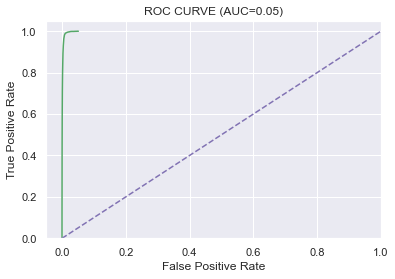

<Figure size 432x288 with 0 Axes>

In [29]:
from sklearn.metrics import roc_curve,auc
#AUC值计算
AUC=auc(FPR,TPR)
#ROC曲线绘制
plt.figure()
plt.title('ROC CURVE (AUC={:.2f})'.format(AUC))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.plot(FPR,TPR,color='g')
plt.plot([0, 1], [0, 1], color='m', linestyle='--')
plt.show()
plt.savefig("predict/WAM_ROC-left{left}-right{right}.png",dpi=400)

In [87]:
# i=1
# threshold=-4
# TP_count = 0
# FP_count = 0
# FN_count = 0
# predict_count = 0
# seq= test_seq_list[i][3000:3200]
# seq_length = len(seq)
# scores = []
# predict_sites = []
# positive_sites = []
# negative_sites = []
# for pos in  range(seq_length-signal_num):
#     signal = seq[pos:pos+signal_num]
#     no_known =pattern.search(signal)
#     if no_known:
#         break
#     else:
#         s=cal_WAM(signal)
#         predict_count +=1
#         print(s)
#         if s > threshold:
# #             scores.append(s)
#             predict_site= pos+4
#             predict_sites.append(predict_site)
#             if predict_site in test_donor_list[i]:
#                 TP_count +=1
#                 positive_sites.append(predict_site)
#             else:
#                 FP_count +=1
#                 negative_sites.append(predict_site)
# print(TP_count)
# print(FP_count)
# print(seq_length)
# print(test_donor_list[i])


0
0
200
[3158, 3504]
[]
[]


In [ ]:
print()